In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.options.display.max_rows = None

path = Path().parent.absolute()
bike_path =  path / "Fahrraddiebstahl.csv"
lor_path = path / "lor_ortsteile.csv"

In [2]:
bike_dtypes = {
    "ANGELEGT_AM": "object",
    "TATZEIT_ANFANG_DATUM": "object",
    "TATZEIT_ANFANG_STUNDE": "int64",
    "TATZEIT_ENDE_DATUM": "object",
    "TATZEIT_ENDE_STUNDE": "int64",
    "LOR": "object",
    "SCHADENSHOEHE": "int64",
    "VERSUCH": "object",
    "ART_DES_FAHRRADS": "object",
    "DELIKT": "object",
    "ERFASSUNGSGRUND": "object",
}

lor_dtypes = {
    "spatial_name": "object",
    "OTEIL": "object",
    "BEZIRK": "object",
    "FLAECHE_HA": "float64",
}


In [3]:
with open(bike_path, "rb") as file:
    bike_data = pd.read_csv(file, encoding="latin1", dtype=bike_dtypes)

with open(lor_path, "rb") as file:
    lor_data = pd.read_csv(file, encoding="utf-8", dtype=lor_dtypes, usecols=['spatial_name', 'OTEIL', 'BEZIRK', 'FLAECHE_HA'])

In [4]:
bike_data["ANGELEGT_AM"] = pd.to_datetime(bike_data["ANGELEGT_AM"], dayfirst=True)
bike_data["TATZEIT_ANFANG_DATUM"] = pd.to_datetime(bike_data["TATZEIT_ANFANG_DATUM"], dayfirst=True)
bike_data["TATZEIT_ENDE_DATUM"] = pd.to_datetime(bike_data["TATZEIT_ENDE_DATUM"], dayfirst=True)

lor_data = lor_data.rename(columns={"spatial_name": "BEZ"})

In [5]:
bike_data.info()
bike_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24610 entries, 0 to 24609
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ANGELEGT_AM            24610 non-null  datetime64[ns]
 1   TATZEIT_ANFANG_DATUM   24610 non-null  datetime64[ns]
 2   TATZEIT_ANFANG_STUNDE  24610 non-null  int64         
 3   TATZEIT_ENDE_DATUM     24610 non-null  datetime64[ns]
 4   TATZEIT_ENDE_STUNDE    24610 non-null  int64         
 5   LOR                    24610 non-null  object        
 6   SCHADENSHOEHE          24610 non-null  int64         
 7   VERSUCH                24610 non-null  object        
 8   ART_DES_FAHRRADS       24610 non-null  object        
 9   DELIKT                 24610 non-null  object        
 10  ERFASSUNGSGRUND        24610 non-null  object        
dtypes: datetime64[ns](3), int64(3), object(5)
memory usage: 2.1+ MB


,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND
0,2023-02-19,2023-02-18,18,2023-02-19,7,03701658,3472,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
1,2023-02-19,2023-02-18,20,2023-02-19,9,01100308,2277,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
2,2023-02-19,2023-02-18,16,2023-02-19,0,06100102,746,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
3,2023-02-19,2023-02-18,17,2023-02-19,0,07601544,1849,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4,2023-02-19,2023-02-17,17,2023-02-17,17,03601346,1863,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [6]:
bike_data["BEZ"] = bike_data["LOR"].str[0:2] + bike_data["LOR"].str[4:6]

In [7]:
lor_data.head(10)


,BEZ,OTEIL,BEZIRK,FLAECHE_HA
0,0101,Mitte,Mitte,1063.8748
1,0102,Moabit,Mitte,768.7909
2,0103,Hansaviertel,Mitte,52.5337
3,0104,Tiergarten,Mitte,516.0672
4,0105,Wedding,Mitte,919.9112
5,0106,Gesundbrunnen,Mitte,610.8368
6,0201,Friedrichshain,Friedrichshain-Kreuzberg,991.2352
7,0202,Kreuzberg,Friedrichshain-Kreuzberg,1033.9178
8,0301,Prenzlauer Berg,Pankow,1096.9869
9,0302,Weißensee,Pankow,790.4559


In [8]:
merged_df = bike_data.merge(lor_data,how="left", on="BEZ")
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24610 entries, 0 to 24609
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ANGELEGT_AM            24610 non-null  datetime64[ns]
 1   TATZEIT_ANFANG_DATUM   24610 non-null  datetime64[ns]
 2   TATZEIT_ANFANG_STUNDE  24610 non-null  int64         
 3   TATZEIT_ENDE_DATUM     24610 non-null  datetime64[ns]
 4   TATZEIT_ENDE_STUNDE    24610 non-null  int64         
 5   LOR                    24610 non-null  object        
 6   SCHADENSHOEHE          24610 non-null  int64         
 7   VERSUCH                24610 non-null  object        
 8   ART_DES_FAHRRADS       24610 non-null  object        
 9   DELIKT                 24610 non-null  object        
 10  ERFASSUNGSGRUND        24610 non-null  object        
 11  BEZ                    24610 non-null  object        
 12  OTEIL                  16267 non-null  object        
 13  B

In [9]:
plot_df = merged_df.groupby("OTEIL").agg(
    {"ANGELEGT_AM": "count", "SCHADENSHOEHE": ["sum", "min", "max"]}
).sort_values(by=("ANGELEGT_AM", "count"), ascending=False)
plot_df["ANGELEGT_AM"].head(6)


,count
OTEIL,
Kreuzberg,925
Hansaviertel,778
Charlottenburg-Nord,532
Friedrichshain,463
Britz,420
Buckow,411


Text(0, 0.5, 'LMP ($/MWh)')

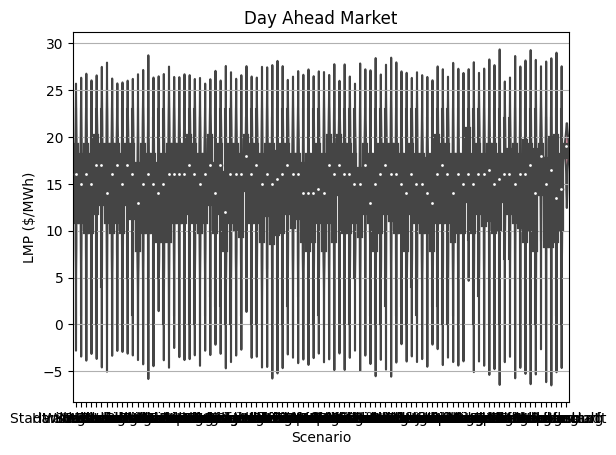

In [16]:
plot_df = merged_df.groupby(["OTEIL", "TATZEIT_ANFANG_STUNDE"]).agg(
    {"ANGELEGT_AM": "count", "SCHADENSHOEHE": ["sum", "min", "max"]}
)

fig, axes = plt.subplots()

sns.violinplot(x=merged_df.OTEIL, y=merged_df.TATZEIT_ANFANG_STUNDE, data_set=merged_df, ax=axes)

axes.set_title('Day Ahead Market')
axes.yaxis.grid(True)
axes.set_xlabel('Scenario')
axes.set_ylabel('LMP ($/MWh)')

In [ ]:
merged_df.groupby(["ART_DES_FAHRRADS", "OTEIL"]).agg(
    {"ANGELEGT_AM": "count", "SCHADENSHOEHE": ["sum", "min", "max"]}
).sort_values(by=("ANGELEGT_AM", "count"), ascending=False).head(10)


ANGELEGT_AM SCHADENSHOEHE          
                                           count           sum min   max
ART_DES_FAHRRADS OTEIL                                                  
Herrenfahrrad    Kreuzberg                   405        425474   0  5900
                 Hansaviertel                392        502583   0  8760
                 Charlottenburg-Nord         268        305485   1  6500
                 Friedrichshain              245        273574   0  7700
Damenfahrrad     Kreuzberg                   237        191122   0  4439
Herrenfahrrad    Britz                       200        200324   0  5600
                 Buckow                      198        203928   0  5084
                 Gesundbrunnen               193        203147  26  6000
Damenfahrrad     Hansaviertel                186        189828   0  3938
Herrenfahrrad    Neukölln                    184        180957   1  5065